## 🌊 Regresión lineal

#### Librerías y ajustes iniciales

In [13]:
import sys

sys.path.append("../../") # go to parent dir

In [14]:
from sklearn.linear_model import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

### 🔨 Construcción de modelos

Probaremos distintos modelos lineales, para cada uno probando con datos escalados y sin escalar y grabandolos en MLFLow, junto con sus métricas

#### Separación en train y test

In [16]:
# Para el modelo con todas las variables
X_train, X_test, y_train, y_test = sep_train_test()
# Eliminamos las columnas repetidas y las columnas temporales (visto en el notebook del analisis)
X_train = X_train.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
X_test = X_test.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])

#### Distribuciones de a variable respuesta en train y test

Text(0.5, 0, 'metros')

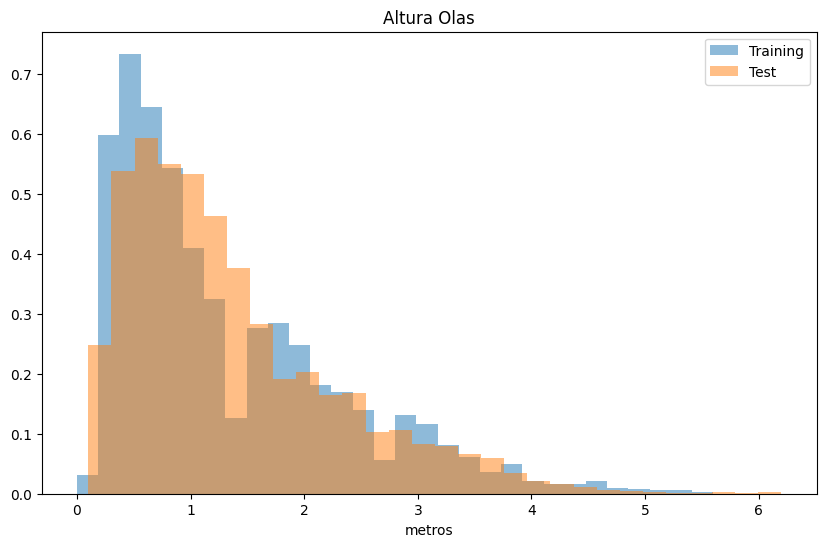

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(y_train, bins=30, alpha=0.5, label='Training', density=True)
ax.hist(y_test, bins=30, alpha=0.5, label='Test', density=True)
plt.legend()
plt.title("Altura Olas")
plt.xlabel("metros")

Analizando las funciones de densidad de los dos conjuntos vemos que se parecen bastante, a excepción de las olas de altura alrededor de 0.5 metros, las cuáles parecen estar en mayor proporción en training que en el conjunto test.

##### Definimos funciones auxiliares para evitar repetir mucho codigo

Estas funciones se encargarán de, pasado el modelo y los datos de entrenamiento y test, encontrar la combinación de los mejores hiperparámetros con varias técnicas posibles (entrenando con **TRAIN** y evaluando con **VALIDACIÓN**). Al final, el modelo entrenado y las métricas sobre el conjunto **TEST** se registran en la base de MLFlow.

In [18]:
# Regresion lineal sin regularización
def lineal_sin_reg(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo regresión lineal multivariable sin regularizar"):
    flo = MLFlow("lineal_sin_reg")
    lr = LinearRegression()
    cv_metrics = cross_validate(lr, x_tr, y_tr, cv=cv_folds(), scoring="neg_root_mean_squared_error", return_train_score=True)
    lr.fit(x_tr, y_tr)
    
    # metricas TEST
    metricas = calcular_metricas(y_te, lr.predict(x_te))
    # metricas CV
    metricas["CV_TEST_RMSE"] = -1 * cv_metrics['test_score'].mean()
    metricas["CV_TRAIN_RMSE"] = -1 * cv_metrics['train_score'].mean()
    print("LINEAR")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, lr, {"random_state": RANDOM_SEED}, metricas, run_name, exp_info)

In [19]:
# Regresion con regularizacion RIDGE

def ridge(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo ridge"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        "max_iter": [None, 100, 500, 1000],
    }
    flo = MLFlow("ridge")

    rdgSearch = GridSearchCV(Ridge(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    rdgSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(rdgSearch, x_te, y_te)
    print("RIDGE GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, rdgSearch.best_estimator_, rdgSearch.best_params_, metricas, run_name+"_grid_search", exp_info)

    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 1)],
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        "max_iter": [None, 100, 500, 1000],
    }
    
    rdgRanSearch = RandomizedSearchCV(Ridge(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    rdgRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(rdgRanSearch, x_te, y_te)
    print("RIDGE RANDOMSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, rdgRanSearch.best_estimator_, rdgRanSearch.best_params_, metricas, run_name+"_random_search", exp_info)

    

In [20]:
# Regresion con regularizacion LASSO

def lasso(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo lasso"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "selection": ['cyclic', 'random'],
        "max_iter": [None, 100, 500, 1000, 2000],
    }
    flo = MLFlow("lasso")

    lasSearch = GridSearchCV(Lasso(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    lasSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(lasSearch, x_te, y_te)
    print("LASSO GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, lasSearch.best_estimator_, lasSearch.best_params_, metricas, run_name+"_grid_search", exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 1)],
        "selection": ['cyclic', 'random'],
        "max_iter": [None, 100, 500, 1000, 2000],
    }
    
    lasRanSearch = RandomizedSearchCV(Lasso(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    lasRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(lasRanSearch, x_te, y_te)
    print("LASSO RANDOMSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, lasRanSearch.best_estimator_, lasRanSearch.best_params_, metricas, run_name+"_random_search", exp_info)


In [21]:
# Regresion con regularizacion ELASTIC NET

def elastic(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo elastic net"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 10)],
        "l1_ratio": [i/100 for i in range(0, 101, 10)],
        "max_iter": [None, 500],
    }
    flo = MLFlow("elastic")

    elSearch = GridSearchCV(ElasticNet(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    elSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(elSearch, x_te, y_te)
    print("ELASTIC GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, elSearch.best_estimator_, elSearch.best_params_, metricas, run_name+"_grid_search", exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "l1_ratio": [i/100 for i in range(0, 101, 5)],
        "max_iter": [None, 100, 500, 1000],
    }
    
    elRanSearch = RandomizedSearchCV(ElasticNet(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    elRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(elRanSearch, x_te, y_te)
    print("ELASTIC RANDOMSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, elRanSearch.best_estimator_, elRanSearch.best_params_, metricas, run_name+"_random_search", exp_info)

In [22]:
# Support vector machines

def SVM(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo SVM con kernel lineal"):
    params = {
        "random_state": [RANDOM_SEED],
        "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        "C": np.logspace(-3, 3, 25),
        "max_iter": [None, 100, 500, 1000],
    }
    flo = MLFlow("svm")

    svmSearch = GridSearchCV(LinearSVR(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    svmSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(svmSearch, x_te, y_te)
    print("SVM GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, svmSearch.best_estimator_, svmSearch.best_params_, metricas, run_name+"_grid_search", exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        "C": np.logspace(-3, 3, 100),
        "max_iter": [None, 100, 500, 1000],
    }
    
    svmRanSearch = RandomizedSearchCV(LinearSVR(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    svmRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(svmRanSearch, x_te, y_te)
    print("SVM RANDOMSEARCH")
    print(metricas)
    
    flo.persist_model_to_mlflow(x_tr, svmRanSearch.best_estimator_, svmRanSearch.best_params_, metricas, run_name+"_random_search", exp_info)

### Modelos usando el conjunto de datos completo

No eliminamos columnas en esta sección para contrastar posteriormente

In [23]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

#### Modelo lineal sin regularización

In [24]:
lineal_sin_reg(X_train, X_test, y_train, y_test, "lineal-sin-regularizar")

2024/04/25 21:41:51 INFO mlflow.tracking.fluent: Experiment with name 'lineal_sin_reg' does not exist. Creating a new experiment.


LINEAR
{'TEST_MAX_ERROR': 2.3924967961023205, 'TEST_ROOT_MEAN_SQ_ERROR': 0.49278774590513297, 'TEST_MEDIAN_ABS_ERROR': 0.31135520503023806, 'TEST_MEAN_ABS_ERROR': 0.3820656755906809, 'CV_TEST_RMSE': 0.4672807059072115, 'CV_TRAIN_RMSE': 0.4641326077038605}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'lineal-sin-regularizar'.
2024/04/25 21:41:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lineal-sin-regular

In [25]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 2.3546404974243327, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569855088064947, 'TEST_MEDIAN_ABS_ERROR': 0.27932137147789604, 'TEST_MEAN_ABS_ERROR': 0.35133992706891015, 'CV_TEST_RMSE': 0.46729693184611987, 'CV_TRAIN_RMSE': 0.4641378143807886}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-lineal-sin-regularizar'.
2024/04/25 21:41:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-lineal-sin-regularizar, version 1
Created version '1' of mo

Vemos que al escalar aparece una mejora en todas las métricas en el conjunto test, aunque el caso de train las métricas empeoran muy poco.

#### Modelo RIDGE

In [26]:
ridge(X_train, X_test, y_train, y_test, "ridge")

2024/04/25 21:41:58 INFO mlflow.tracking.fluent: Experiment with name 'ridge' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-pac

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.3531787208611483, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4563938594375065, 'TEST_MEDIAN_ABS_ERROR': 0.27957397667003825, 'TEST_MEAN_ABS_ERROR': 0.3508746796097043, 'CV_TEST_RMSE': 0.46719788670283807, 'CV_TRAIN_RMSE': 0.4641718321753362}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3531787208611483, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4563938594375065, 'TEST_MEDIAN_ABS_ERROR': 0.27957397667003825, 'TEST_MEAN_ABS_ERROR': 0.3508746796097043, 'CV_TEST_RMSE': 0.46719788670283807, 'CV_TRAIN_RMSE': 0.4641718321753362}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

In [27]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-ridge")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.355928065202297, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45693540222874396, 'TEST_MEDIAN_ABS_ERROR': 0.2799912960898051, 'TEST_MEAN_ABS_ERROR': 0.35131689877017214, 'CV_TEST_RMSE': 0.4672402071370792, 'CV_TRAIN_RMSE': 0.4641458551070413}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-ridge_grid_search'.
2024/04/25 21:44:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-ridge_grid_search, version 1
Created version '1' of model 'escal

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3559353001746732, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569347464287433, 'TEST_MEDIAN_ABS_ERROR': 0.2799880998267854, 'TEST_MEAN_ABS_ERROR': 0.35131630875357645, 'CV_TEST_RMSE': 0.46724010842665314, 'CV_TRAIN_RMSE': 0.4641458646153998}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-ridge_random_search'.
2024/04/25 21:45:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-ridge_random_search, version 1
Created version '1' of model 'e

Vemos que al escalar aparece una mejora en todas las métricas en el conjunto test. Además, son mejores que en el anterior modelo. Mencionar que el random search encuentra una mejor combinación de parámteros

#### Modelo LASSO

In [28]:
lasso(X_train, X_test, y_train, y_test, "lasso")

2024/04/25 21:45:04 INFO mlflow.tracking.fluent: Experiment with name 'lasso' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e+01, tolerance: 3.761e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e+01, tolerance: 3.791e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Conve

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.3853832257290435, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4549195856756683, 'TEST_MEDIAN_ABS_ERROR': 0.2816930125817354, 'TEST_MEAN_ABS_ERROR': 0.3509525324191503, 'CV_TEST_RMSE': 0.47542496241325016, 'CV_TRAIN_RMSE': 0.4740070044043908}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3854133118335348, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45491700469692087, 'TEST_MEDIAN_ABS_ERROR': 0.2817499787362401, 'TEST_MEAN_ABS_ERROR': 0.35095124855575865, 'CV_TEST_RMSE': 0.47542573340911565, 'CV_TRAIN_RMSE': 0.4740061388373914}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

In [29]:
lasso(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-lasso")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tyomikjan/UNIVERSITY/P

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.4498606560859106, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570765064478258, 'TEST_MEDIAN_ABS_ERROR': 0.2842102401459931, 'TEST_MEAN_ABS_ERROR': 0.35135992046605474, 'CV_TEST_RMSE': 0.47652691416331133, 'CV_TRAIN_RMSE': 0.475195882350794}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-lasso_grid_search'.
2024/04/25 21:45:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-lasso_grid_search, version 1
Created version '1' of model 'escal

LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4498606560859106, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570765064478258, 'TEST_MEDIAN_ABS_ERROR': 0.2842102401459931, 'TEST_MEAN_ABS_ERROR': 0.35135992046605474, 'CV_TEST_RMSE': 0.47652691416331133, 'CV_TRAIN_RMSE': 0.475195882350794}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-lasso_random_search'.
2024/04/25 21:45:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-lasso_random_search, version 1
Created version '1' of model 'e

Sorprendentemente, Lasso predice peor si escalamos los datos. Además, este modelo predice peor que los modelos escalados de ridge y linear regression

#### Modelo ELASTIC NET

In [30]:
elastic(X_train, X_test, y_train, y_test, "elastic")

2024/04/25 21:45:20 INFO mlflow.tracking.fluent: Experiment with name 'elastic' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.214e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.198e+02, 

ELASTIC GRIDSEARCH
{'TEST_MAX_ERROR': 2.34547582441855, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45362121485907814, 'TEST_MEDIAN_ABS_ERROR': 0.2785247075974797, 'TEST_MEAN_ABS_ERROR': 0.3484665785286415, 'CV_TEST_RMSE': 0.4680809696669477, 'CV_TRAIN_RMSE': 0.4652965889129111}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

ELASTIC RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3506075129027693, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4530781518435188, 'TEST_MEDIAN_ABS_ERROR': 0.2794537684444716, 'TEST_MEAN_ABS_ERROR': 0.34828107949039866, 'CV_TEST_RMSE': 0.46865042113198474, 'CV_TRAIN_RMSE': 0.466200618364138}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'elastic_random_search'.
2024/04/25 21:45:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: elastic_random_search, version 1
Created version '1' of model 'elastic_random_

In [31]:
elastic(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-elastic")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.172e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.144e+02, tolerance: 3.740e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

ELASTIC GRIDSEARCH
{'TEST_MAX_ERROR': 2.385942961973889, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4548760768692559, 'TEST_MEDIAN_ABS_ERROR': 0.27993130324977683, 'TEST_MEAN_ABS_ERROR': 0.34952371979807273, 'CV_TEST_RMSE': 0.46739383515167016, 'CV_TRAIN_RMSE': 0.46460845726663874}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-elastic_grid_search'.
2024/04/25 21:45:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-elastic_grid_search, version 1
Created version '1' of model 'e

ELASTIC RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4016246810082604, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4542007357967838, 'TEST_MEDIAN_ABS_ERROR': 0.2799769868093489, 'TEST_MEAN_ABS_ERROR': 0.34884522826940634, 'CV_TEST_RMSE': 0.4685406251687031, 'CV_TRAIN_RMSE': 0.4660245683768623}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-elastic_random_search'.
2024/04/25 21:45:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-elastic_random_search, version 1
Created version '1' of mode

En este caso igual que Lasso, predice peor al escalar los datos. Si no escalamos los datos parecer ser que es el mejor modelo hasta ahora.

#### Modelo SVM

In [32]:
SVM(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-svm")

2024/04/25 21:45:39 INFO mlflow.tracking.fluent: Experiment with name 'svm' does not exist. Creating a new experiment.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: F

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 2.3620284742844917, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4573382589407294, 'TEST_MEDIAN_ABS_ERROR': 0.28185406444211797, 'TEST_MEAN_ABS_ERROR': 0.35154390959020365, 'CV_TEST_RMSE': 0.46723973861121904, 'CV_TRAIN_RMSE': 0.46421646199269706}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-svm_grid_search'.
2024/04/25 21:46:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-svm_grid_search, version 1
Created version '1' of model 'escalado-

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3635858041102873, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45700349800980394, 'TEST_MEDIAN_ABS_ERROR': 0.28202532489965004, 'TEST_MEAN_ABS_ERROR': 0.3513217730669858, 'CV_TEST_RMSE': 0.4672331654818227, 'CV_TRAIN_RMSE': 0.4642220727390128}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-svm_random_search'.
2024/04/25 21:46:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-svm_random_search, version 1
Created version '1' of model 'escal

El que más tiempo ha tardado en ejecutar. En este caso el escalado ayuda, pero no consigue mejorar el resultado de ElasticNet

### Modelo usando selección de variables MANUAL

#### Seleccion de variables

In [33]:
cols = ['moonphase', 'temp', 'rh', 'pressure',
       'vis', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N',
       'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE',
       'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW',
       'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia', 'Nubosidad']
# guardamos para poder usar despues en el ajuste automatico
X_train_full = X_train.copy()
X_test_full = X_test.copy()

X_train = X_train[cols]
X_test = X_test[cols]

In [34]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'rh', 'pressure', 'vis',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

#### Modelo lineal sin regularización

In [35]:
lineal_sin_reg(X_train, X_test, y_train, y_test, "manual-selection-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 2.3925406083885363, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45700269100202406, 'TEST_MEDIAN_ABS_ERROR': 0.28138712684071376, 'TEST_MEAN_ABS_ERROR': 0.35054774227298535, 'CV_TEST_RMSE': 0.46959551051187826, 'CV_TRAIN_RMSE': 0.4665570508791218}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

In [36]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-manual-selection-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 2.392540608388522, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45700269100202534, 'TEST_MEDIAN_ABS_ERROR': 0.2813871268407142, 'TEST_MEAN_ABS_ERROR': 0.35054774227298624, 'CV_TEST_RMSE': 0.4695955105118784, 'CV_TRAIN_RMSE': 0.4665570508791218}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-lineal-sin-regularizar'.
2024/04/25 21:46:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-lineal-sin-regularizar, v

#### Modelo RIDGE

In [37]:
ridge(X_train, X_test, y_train, y_test, "manual-selection-ridge")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.3990459841151157, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45681929545031036, 'TEST_MEDIAN_ABS_ERROR': 0.2823021900635275, 'TEST_MEAN_ABS_ERROR': 0.3505093894592272, 'CV_TEST_RMSE': 0.46951218743240786, 'CV_TRAIN_RMSE': 0.46659857617126577}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.399042525045367, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45681808388169953, 'TEST_MEDIAN_ABS_ERROR': 0.2822958645238195, 'TEST_MEAN_ABS_ERROR': 0.35050827646270294, 'CV_TEST_RMSE': 0.4695121063442468, 'CV_TRAIN_RMSE': 0.46659859120194136}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

In [38]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-manual-selection-ridge")

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.3929768433198553, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569492534339473, 'TEST_MEDIAN_ABS_ERROR': 0.2815494287147423, 'TEST_MEAN_ABS_ERROR': 0.3505091970393953, 'CV_TEST_RMSE': 0.46957076287179345, 'CV_TRAIN_RMSE': 0.46655755956366696}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-ridge_grid_search'.
2024/04/25 21:48:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-ridge_grid_search, version 1
C

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3929768433198553, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569492534339473, 'TEST_MEDIAN_ABS_ERROR': 0.2815494287147423, 'TEST_MEAN_ABS_ERROR': 0.3505091970393953, 'CV_TEST_RMSE': 0.46957076287179345, 'CV_TRAIN_RMSE': 0.46655755956366696}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-ridge_random_search'.
2024/04/25 21:48:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-ridge_random_search, version

#### Modelo LASSO (no cambia apenas el resultado, pues el algoritmo ya se encarga de quitar variables por su cuenta)

In [39]:
lasso(X_train, X_test, y_train, y_test, "manual-selection-lasso")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tyomikjan/UNIVERSITY/P

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.417516751239333, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4554368874019835, 'TEST_MEDIAN_ABS_ERROR': 0.28056516246359636, 'TEST_MEAN_ABS_ERROR': 0.35045989391095855, 'CV_TEST_RMSE': 0.4775145318250624, 'CV_TRAIN_RMSE': 0.4762049187592563}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'manual-selection-lasso_grid_search'.
2024/04/25 21:48:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: manual-selection-lasso_grid_search, version 1
Created version '1'

LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.417516751239333, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4554368874019835, 'TEST_MEDIAN_ABS_ERROR': 0.28056516246359636, 'TEST_MEAN_ABS_ERROR': 0.35045989391095855, 'CV_TEST_RMSE': 0.4775145318250624, 'CV_TRAIN_RMSE': 0.4762049187592563}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'manual-selection-lasso_random_search'.
2024/04/25 21:48:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: manual-selection-lasso_random_search, version 1
Created version

In [40]:
lasso(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-manual-selection-lasso")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tyomikjan/UNIVERSITY/P

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.4498019293106763, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570786476870413, 'TEST_MEDIAN_ABS_ERROR': 0.2842329327858378, 'TEST_MEAN_ABS_ERROR': 0.35136276157172674, 'CV_TEST_RMSE': 0.4765272916725132, 'CV_TRAIN_RMSE': 0.47519595842307594}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-lasso_grid_search'.
2024/04/25 21:48:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-lasso_grid_search, version 1
C

LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4498019293106763, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570786476870413, 'TEST_MEDIAN_ABS_ERROR': 0.2842329327858378, 'TEST_MEAN_ABS_ERROR': 0.35136276157172674, 'CV_TEST_RMSE': 0.4765272916725132, 'CV_TRAIN_RMSE': 0.47519595842307594}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-lasso_random_search'.
2024/04/25 21:48:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-lasso_random_search, version

#### Modelo ELASTIC NET

In [41]:
elastic(X_train, X_test, y_train, y_test, "manual-selection-elastic")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.261e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.232e+02, tolerance: 3.791e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

ELASTIC GRIDSEARCH
{'TEST_MAX_ERROR': 2.3829917588509737, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45366150866373955, 'TEST_MEDIAN_ABS_ERROR': 0.2767432216097617, 'TEST_MEAN_ABS_ERROR': 0.3477178870129286, 'CV_TEST_RMSE': 0.47036768813569463, 'CV_TRAIN_RMSE': 0.4677005978451511}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module i

ELASTIC RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3913224529925046, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45301151887989294, 'TEST_MEDIAN_ABS_ERROR': 0.27530091976344623, 'TEST_MEAN_ABS_ERROR': 0.34745668759912285, 'CV_TEST_RMSE': 0.47089499892908754, 'CV_TRAIN_RMSE': 0.4685658025638534}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'manual-selection-elastic_random_search'.
2024/04/25 21:49:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: manual-selection-elastic_random_search, version 1
Created ver

In [42]:
elastic(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-manual-selection-elastic")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.203e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.180e+02, tolerance: 3.791e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

ELASTIC GRIDSEARCH
{'TEST_MAX_ERROR': 2.4121208025359966, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4554009508008006, 'TEST_MEDIAN_ABS_ERROR': 0.28074490176573413, 'TEST_MEAN_ABS_ERROR': 0.34946875947503175, 'CV_TEST_RMSE': 0.46952610525172583, 'CV_TRAIN_RMSE': 0.4668069814052659}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-elastic_grid_search'.
2024/04/25 21:49:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-elastic_grid_search, version

ELASTIC RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4192594010834987, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45474909751054043, 'TEST_MEDIAN_ABS_ERROR': 0.28087049735482206, 'TEST_MEAN_ABS_ERROR': 0.34907645533434106, 'CV_TEST_RMSE': 0.47007209257000593, 'CV_TRAIN_RMSE': 0.4676263884721192}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-elastic_random_search'.
2024/04/25 21:49:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-elastic_random_search, ver

#### Modelo SVM

In [43]:
SVM(X_train, X_test, y_train, y_test, "manual-selection-svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tyomikjan/UN

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 2.514886788560067, 'TEST_ROOT_MEAN_SQ_ERROR': 0.516517945433458, 'TEST_MEDIAN_ABS_ERROR': 0.3195180190004107, 'TEST_MEAN_ABS_ERROR': 0.39688820260733365, 'CV_TEST_RMSE': 0.5266085312575219, 'CV_TRAIN_RMSE': 0.5241778956038854}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'manual-selection-svm_grid_search'.
2024/04/25 21:49:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: manual-selection-svm_grid_search, version 1
Created version '1' of 

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 2.51661740674575, 'TEST_ROOT_MEAN_SQ_ERROR': 0.5164802731751297, 'TEST_MEDIAN_ABS_ERROR': 0.31936989724417986, 'TEST_MEAN_ABS_ERROR': 0.3967705858308707, 'CV_TEST_RMSE': 0.5265510845925333, 'CV_TRAIN_RMSE': 0.5240624616978894}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'manual-selection-svm_random_search'.
2024/04/25 21:50:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: manual-selection-svm_random_search, version 1
Created version '1'

In [44]:
SVM(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-manual-selection-svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 2.4021080595846795, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4612150587826764, 'TEST_MEDIAN_ABS_ERROR': 0.2821305510477732, 'TEST_MEAN_ABS_ERROR': 0.35286950438711273, 'CV_TEST_RMSE': 0.46951607934211187, 'CV_TRAIN_RMSE': 0.4669380568427912}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-svm_grid_search'.
2024/04/25 21:50:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-svm_grid_search, version 1
Creat

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4022829637578518, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4613265856295621, 'TEST_MEDIAN_ABS_ERROR': 0.28200606100201864, 'TEST_MEAN_ABS_ERROR': 0.352932566089318, 'CV_TEST_RMSE': 0.46951391578763896, 'CV_TRAIN_RMSE': 0.4669565343952198}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-manual-selection-svm_random_search'.
2024/04/25 21:50:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-manual-selection-svm_random_search, version 1
C

En general, podemos decir que la selección de variables manual ha empeorado los resultados, sobre todo reflejandose en el TEST_MAX_ERROR. Excepto para Elastic Net, en el cual ha conseguido la menor raiz de MCE

### Modelo usando selección de variables AUTOMATICA
(solo modelos Ridge, LinearRegression y SVM, sobre datos ESCALADOS porque se han tenido en cuenta las variables escaladas en la selección)

#### Modelo lineal sin regularización

In [45]:
cols = ['dewPt', 'rh', 'pressure', 'wc', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR', 'PeriodoOlas', 'Nubosidad']

X_train = X_train_full[cols]
X_test = X_test_full[cols]
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['dewPt', 'rh', 'pressure', 'wc', 'uv_index',
                                  'PeriodoOlas', 'Nubosidad'])])

In [46]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-auto-selection-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 3.5343248135498246, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6717436563340571, 'TEST_MEDIAN_ABS_ERROR': 0.43987798686646384, 'TEST_MEAN_ABS_ERROR': 0.5280188527538002, 'CV_TEST_RMSE': 0.6706479034916522, 'CV_TRAIN_RMSE': 0.669061567904042}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-auto-selection-lineal-sin-regularizar'.
2024/04/25 21:50:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-auto-selection-lineal-sin-regularizar, versi

#### Modelo RIDGE

In [47]:
cols = ['dewPt', 'rh', 'pressure', 'wc', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR', 'PeriodoOlas', 'Nubosidad']

X_train = X_train_full[cols]
X_test = X_test_full[cols]
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['dewPt', 'rh', 'pressure', 'wc', 'uv_index',
                                  'PeriodoOlas', 'Nubosidad'])])

In [48]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-auto-selection-ridge")

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 3.534871336284998, 'TEST_ROOT_MEAN_SQ_ERROR': 0.671734735819351, 'TEST_MEDIAN_ABS_ERROR': 0.43982596578096533, 'TEST_MEAN_ABS_ERROR': 0.5280090870575266, 'CV_TEST_RMSE': 0.6706424917613472, 'CV_TRAIN_RMSE': 0.6690626975538295}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-auto-selection-ridge_grid_search'.
2024/04/25 21:51:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-auto-selection-ridge_grid_search, version 1
Creat

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 3.5348768249045968, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6717346228072355, 'TEST_MEDIAN_ABS_ERROR': 0.4398172597746784, 'TEST_MEAN_ABS_ERROR': 0.5280089769637228, 'CV_TEST_RMSE': 0.6706424535229667, 'CV_TRAIN_RMSE': 0.6690627204586874}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-auto-selection-ridge_random_search'.
2024/04/25 21:51:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-auto-selection-ridge_random_search, version 1
C

#### Modelo SVM

In [49]:
cols = ['temp', 'dewPt', 'rh', 'pressure', 'wc', 'feels_like', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'Nubosidad']

X_train = X_train_full[cols]
X_test = X_test_full[cols]
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['temp', 'dewPt', 'rh', 'pressure', 'wc',
                                  'feels_like', 'uv_index', 'Nubosidad'])])

In [50]:
SVM(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "escalado-auto-selection-svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 3.6015445831571844, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6894570057193695, 'TEST_MEDIAN_ABS_ERROR': 0.4434340317139235, 'TEST_MEAN_ABS_ERROR': 0.5418118169540765, 'CV_TEST_RMSE': 0.6901106598799651, 'CV_TRAIN_RMSE': 0.6886448902011739}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-auto-selection-svm_grid_search'.
2024/04/25 21:51:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-auto-selection-svm_grid_search, version 1
Created v

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 3.6009120867370115, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6895041998916513, 'TEST_MEDIAN_ABS_ERROR': 0.443366370238136, 'TEST_MEAN_ABS_ERROR': 0.541853701132044, 'CV_TEST_RMSE': 0.6901071441001057, 'CV_TRAIN_RMSE': 0.6886399551857673}


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'escalado-auto-selection-svm_random_search'.
2024/04/25 21:51:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: escalado-auto-selection-svm_random_search, version 1
Creat

El ajuste automático de columnas no ha funcionado como queríamos, pues ha empeorado sustancialmente casi todas las métricas de los modelos. Esto se debe a que estabamos seleccionando las columnas en función de los hiperparámetros por defecto en vez de hacerlo en cada iteración lo cuál podría verse limitado por la capacidad de cómputo de nuestros ordenadores.

### Conclusión

En este caso hemos visto que:
1. Al escalar los modelos hay modelos que mejoran en las métricas fijadas(Linear, Ridge, SVM) y otros que empeoran (Lasso, Elastic)
2. El modelo de Elastic Net en sus versiones de cada conjunto de columnas suele ser el mejor en cuanto a las métricas
3. El escalado mejora mucho el rendimiento y acelera el entrenamiento del modelo
4. El modelo de SVM no es el mejor para esta tarea